# Plotting Results of the Tolman-Eichenbaum Machine


### Importing Required Libraries
Here, we import all the necessary libraries and modules required for plotting the results of the trained TEM models.

In [1]:
import importlib
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import neuralplayground.agents.whittington_2020_extras.whittington_2020_analyse as analyse
from neuralplayground.plotting import PlotSim
from neuralplayground.comparison import GridScorer

### Setting Up Simulation Parameters
We define the simulation ID, save path, and plotting loop parameters to set up the simulation. We are also able to `fetch_model_path` to retrieve pre-trained models from Gin.

In [2]:
simulation_id = "TEM_custom_plot_sim"
from neuralplayground.saved_models import fetch_model_path
# save_path = fetch_model_path("tem_in_2D")
save_path= 'TEM_results_test/'
plotting_loop_params = {"n_walk": 2000}

### Loading Model Parameters and Weights
Load the training dictionary, model weights, and model specifications. We also initialize the TEM model and load its weights and hyper-parameters from the saved files.


In [3]:
training_dict = pd.read_pickle(os.path.join(os.getcwd(), save_path, "params.dict"))
model_weights = pd.read_pickle(os.path.join(save_path, "agent"))
model_spec = importlib.util.spec_from_file_location("model", save_path + "whittington_2020_model.py")
model = importlib.util.module_from_spec(model_spec)
model_spec.loader.exec_module(model)
params = pd.read_pickle(os.path.join(save_path, "agent_hyper"))
tem = model.Model(params)
tem.load_state_dict(model_weights)
tem.eval()

Model(
  (alpha): ParameterList(
      (0): Parameter containing: [torch.float32 of size ]
      (1): Parameter containing: [torch.float32 of size ]
      (2): Parameter containing: [torch.float32 of size ]
      (3): Parameter containing: [torch.float32 of size ]
      (4): Parameter containing: [torch.float32 of size ]
  )
  (w_p): ParameterList(
      (0): Parameter containing: [torch.float32 of size ]
      (1): Parameter containing: [torch.float32 of size ]
      (2): Parameter containing: [torch.float32 of size ]
      (3): Parameter containing: [torch.float32 of size ]
      (4): Parameter containing: [torch.float32 of size ]
  )
  (g_init): ParameterList(
      (0): Parameter containing: [torch.float32 of size 30]
      (1): Parameter containing: [torch.float32 of size 30]
      (2): Parameter containing: [torch.float32 of size 24]
      (3): Parameter containing: [torch.float32 of size 18]
      (4): Parameter containing: [torch.float32 of size 18]
  )
  (logsig_g_init): Param

### Initializing Simulation
We initialize the simulation by creating an instance of the `PlotSim` class and passing the required parameters.

In [4]:
sim = PlotSim(
    simulation_id=simulation_id,
    agent_class=training_dict["agent_class"],
    agent_params=training_dict["agent_params"],
    env_class=training_dict["env_class"],
    env_params=training_dict["env_params"],
    plotting_loop_params=plotting_loop_params,
)

### Plotting Simulation
Here, we simulate an agent's trajectory through it's environment; this environment is, by default, the same as the one it was trained in. We also plot the trajectory of the trainedn agent in it's environment.

---> Initializing models
---> Plotting loop
---> Finished


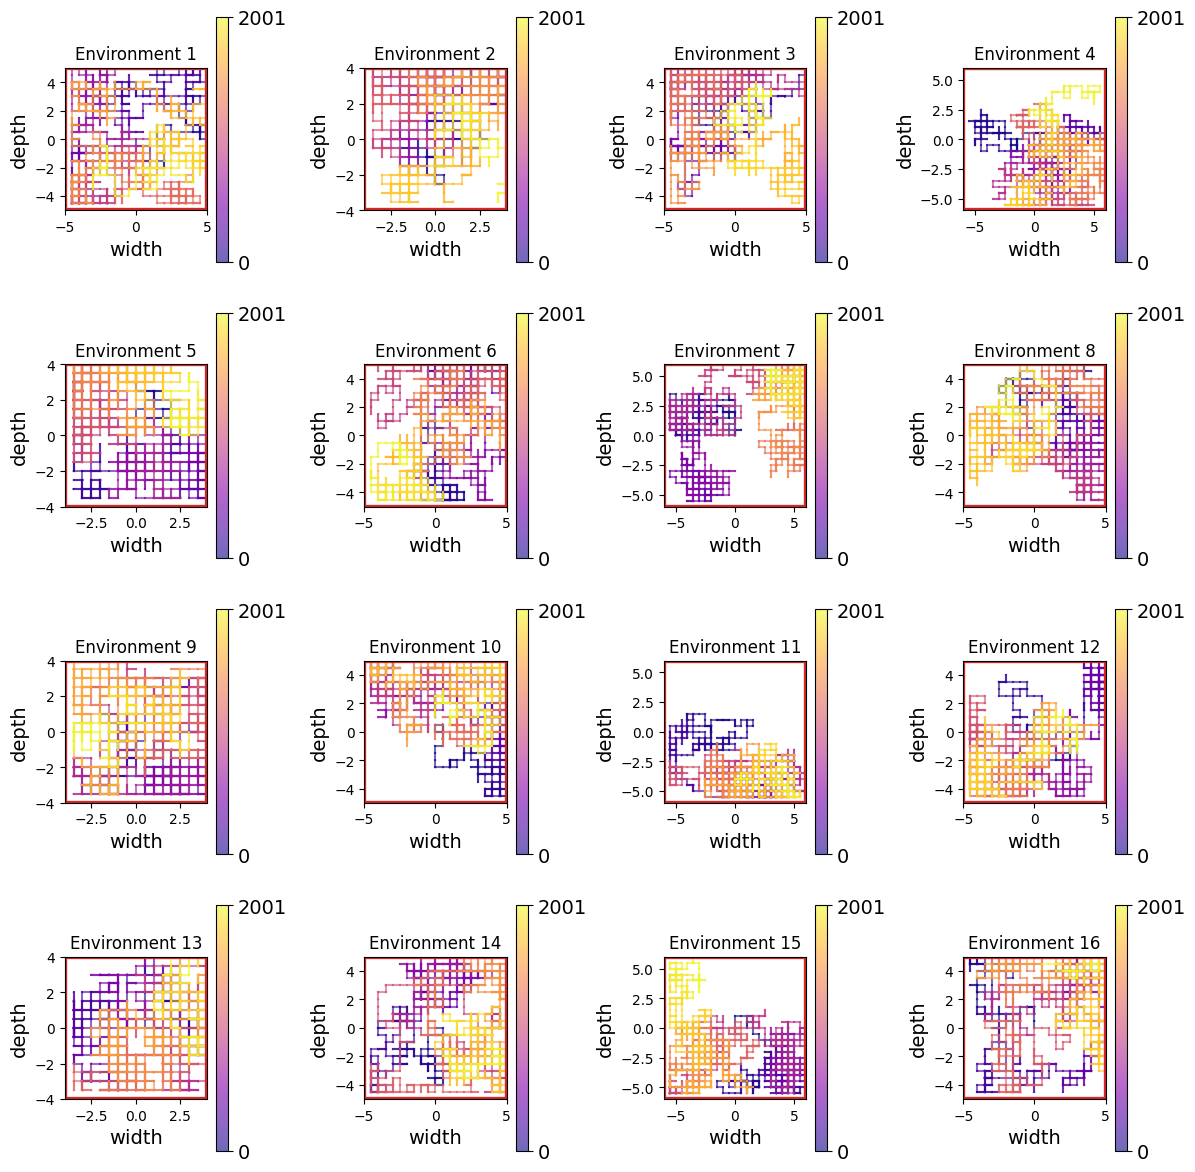

In [5]:
trained_agent, trained_env = sim.plot_sim(save_path, random_state=False, custom_state=[0.0, 0.0])
trained_env.plot_trajectories();

### Loading Environments and Model Input
We load the trained agent's trajectory, as well as information it collected about it's environment during the plotting simulation.

In [6]:
with open(os.path.join(save_path, "NPG_environments.pkl"), "rb") as f:
    environments = pickle.load(f)
with open(os.path.join(save_path, "NPG_model_input.pkl"), "rb") as f:
    model_input = pickle.load(f)

### Plotting Run
This is where we update the agent's internal representation, by running it through our virtual environment. For example, it is during these interactions between agent and environment that grid and place cells are generated.

In [7]:
training_dict["params"] = training_dict["agent_params"]
del training_dict["agent_params"]
agent = training_dict["agent_class"](**training_dict["params"])
agent.plot_run(tem, model_input, environments)
print(f"Zero-shot performance: {np.mean(agent.zero_shot) * 100:.2f}%")

Zero-shot performance: 3.79%


### Plotting Grid Cell and Place Cell Rate Maps
We plot both the grid cell and place cell rate maps using the `plot_rate_map` method. These are plotted at 5 frequencies, each containing between 18 and 30 rate maps for individual cells.

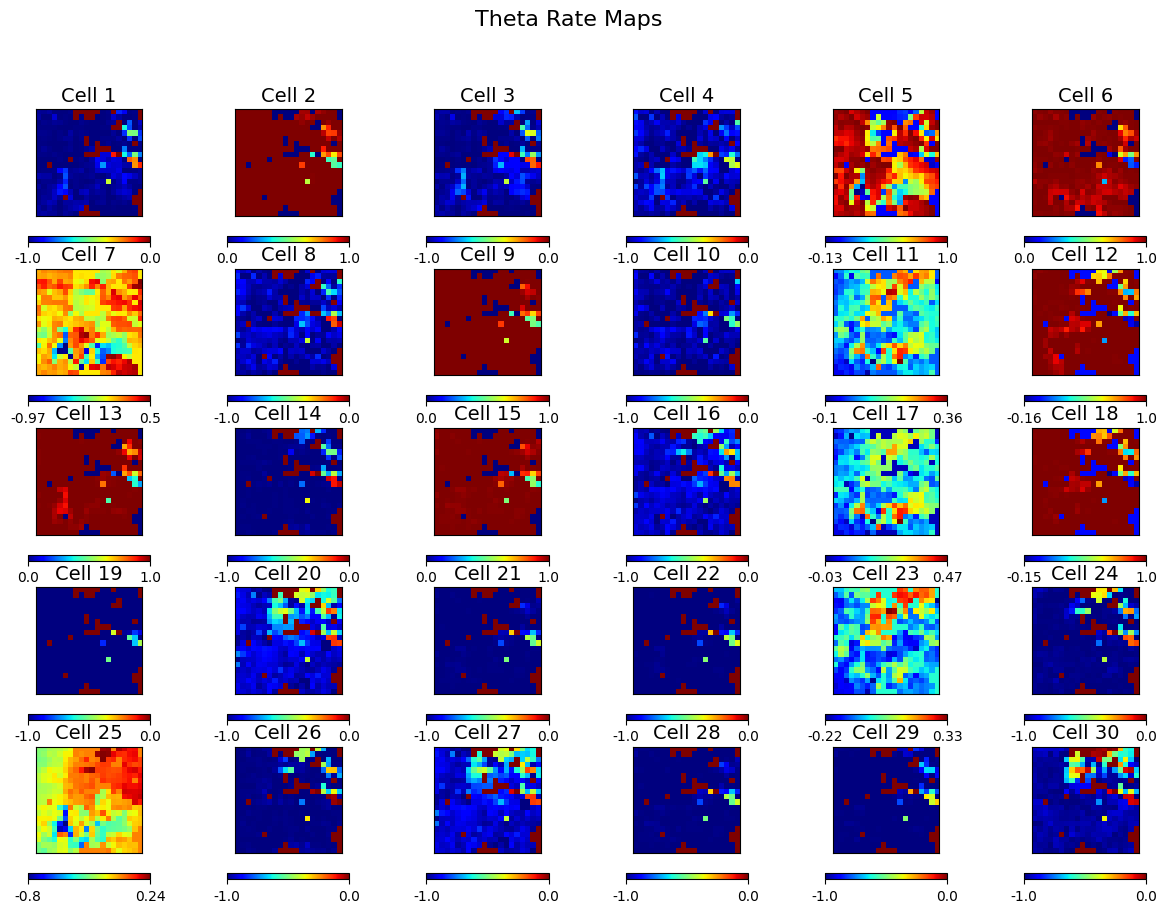

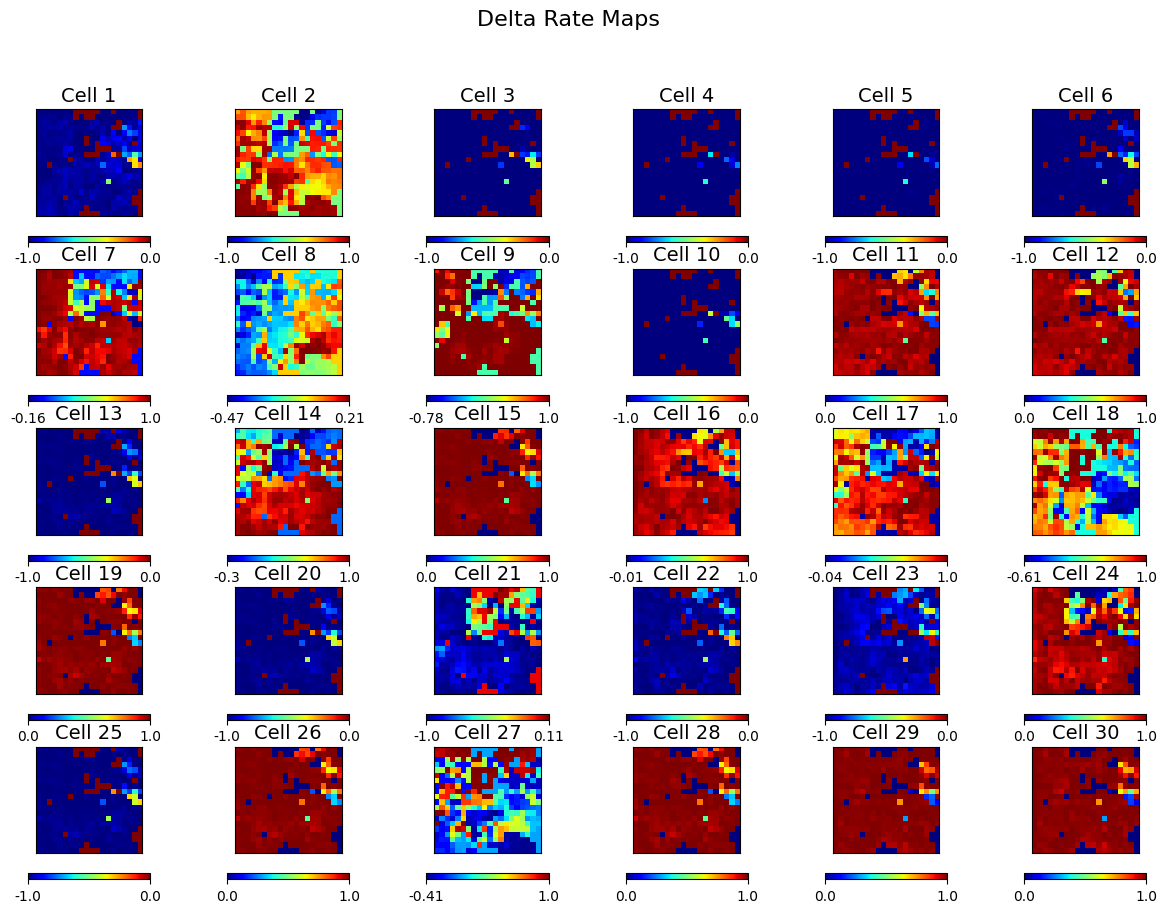

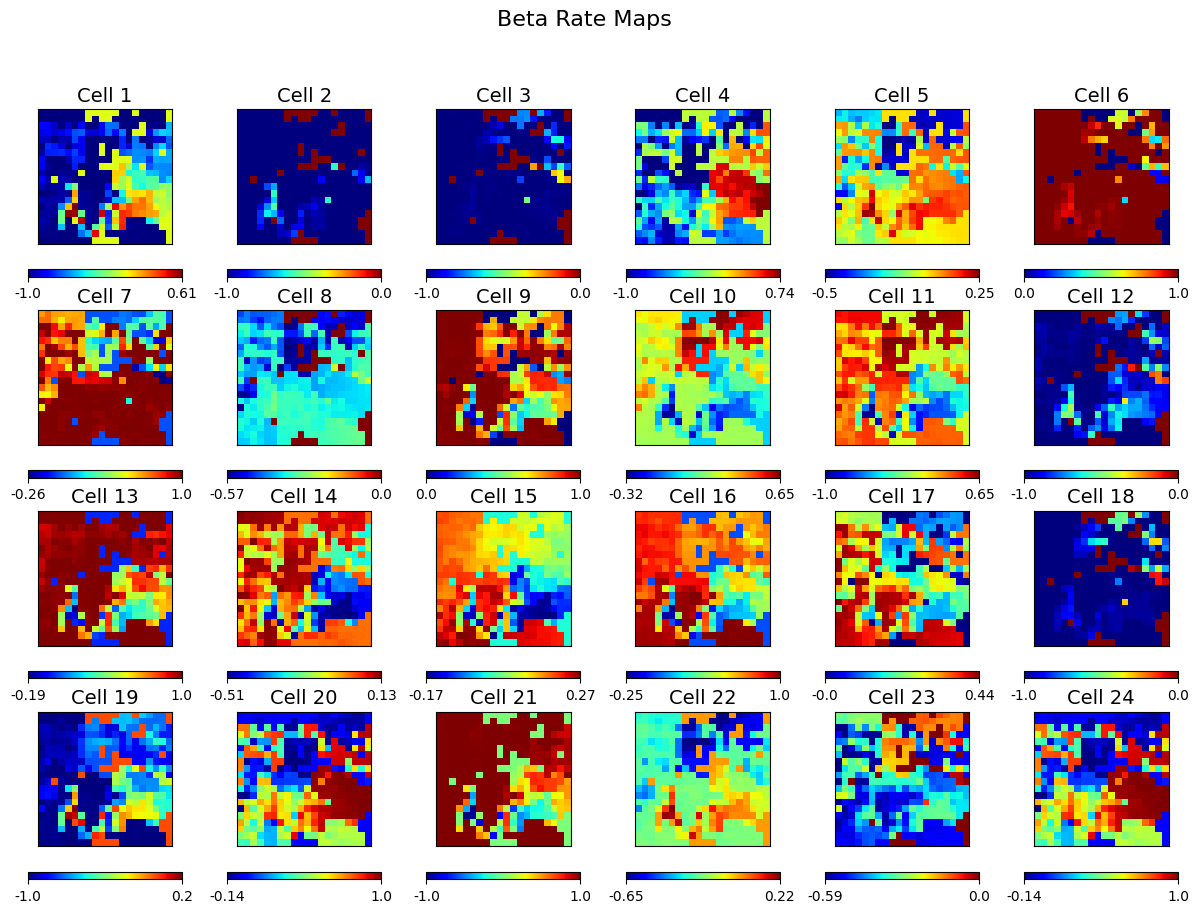

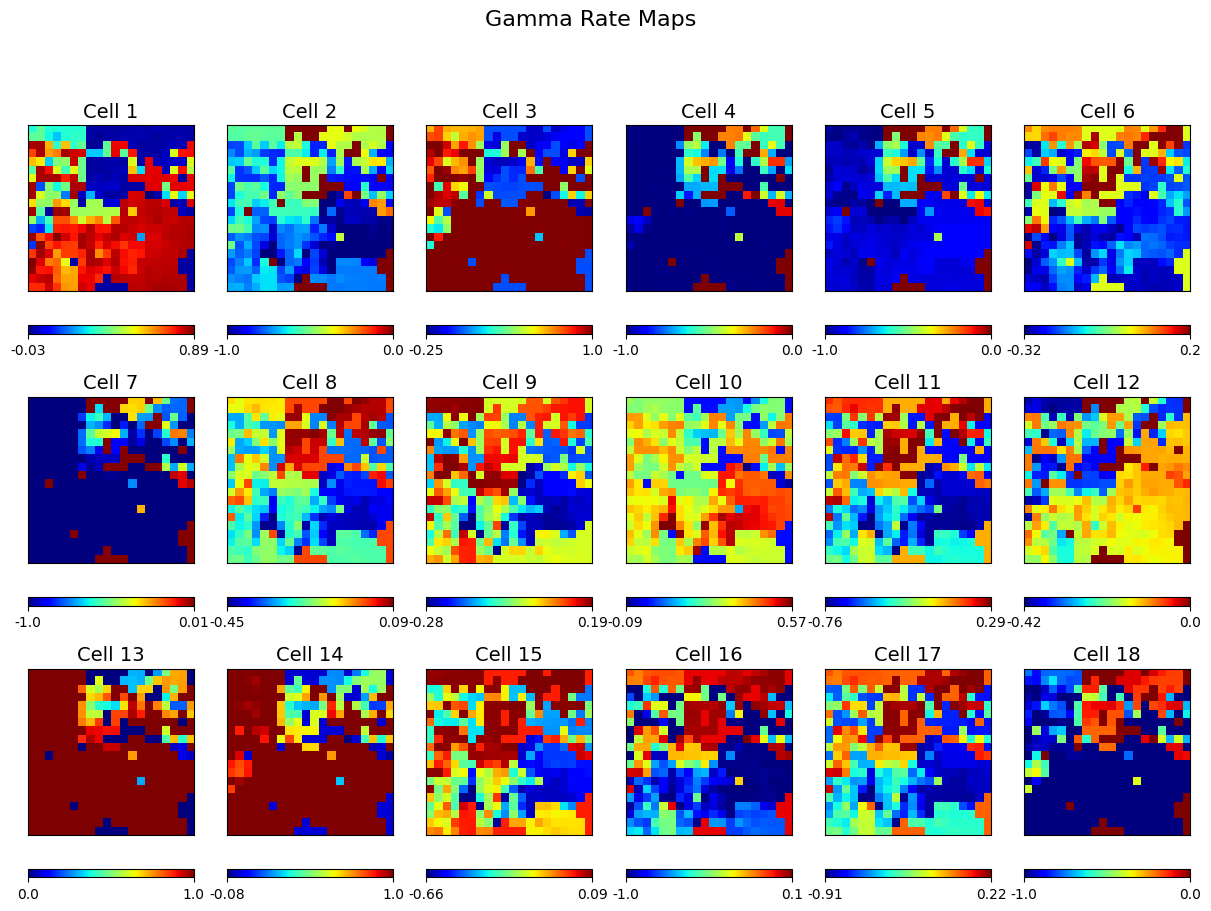

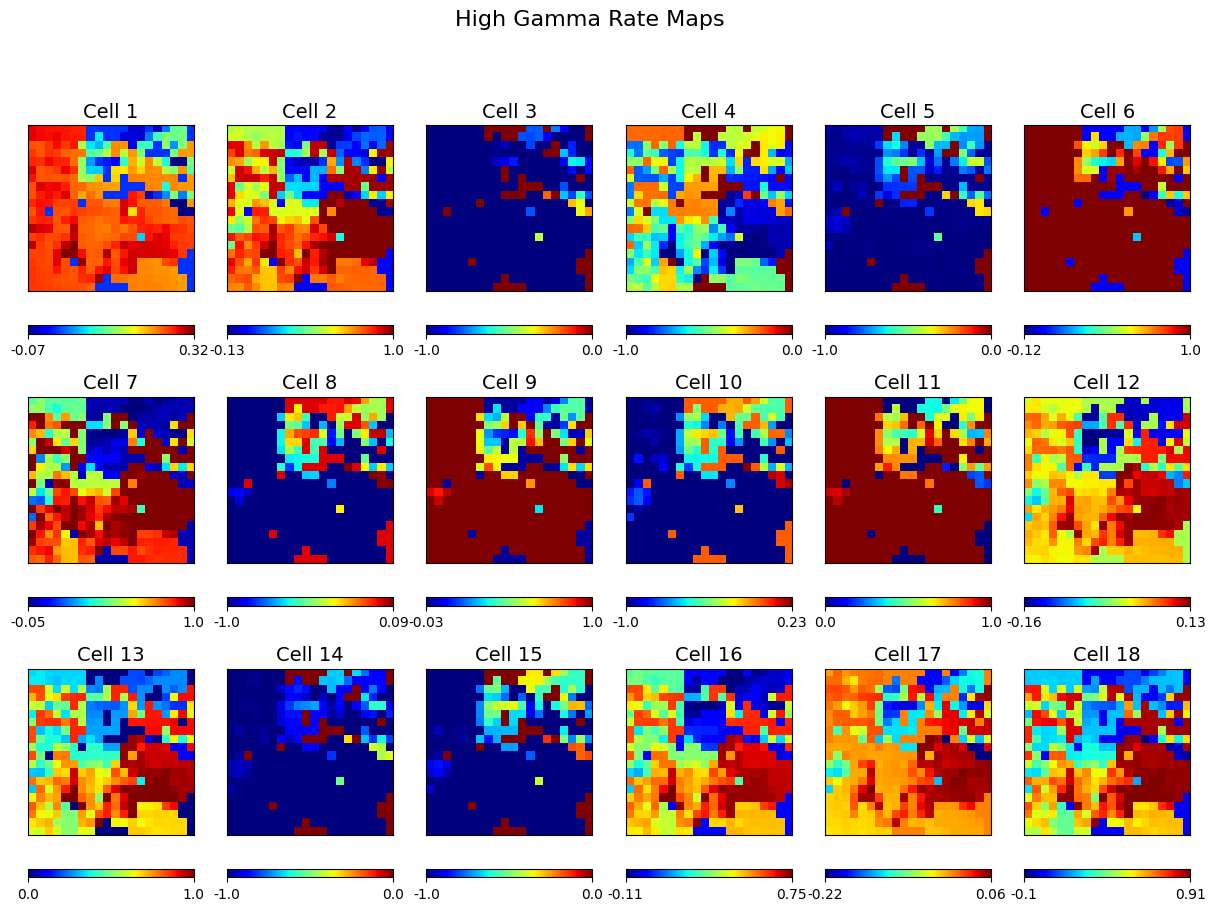

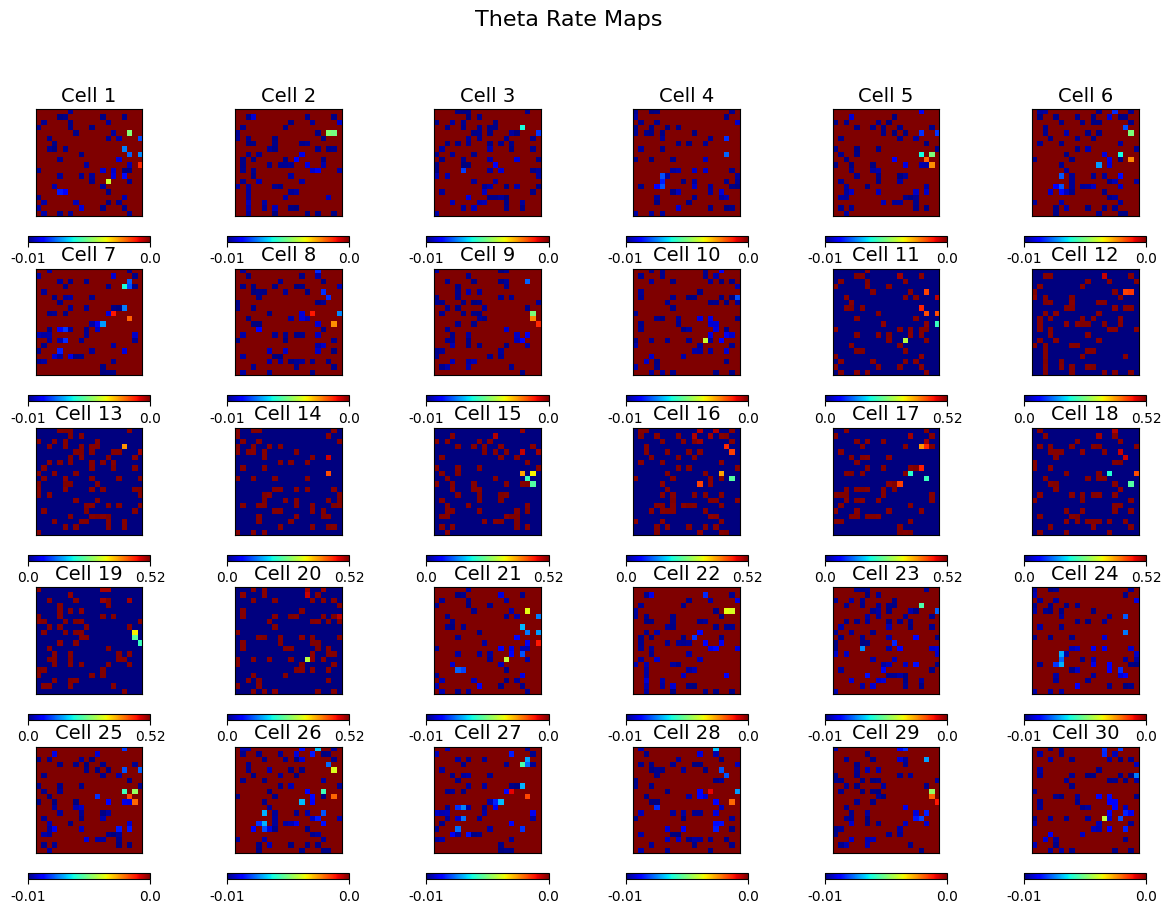

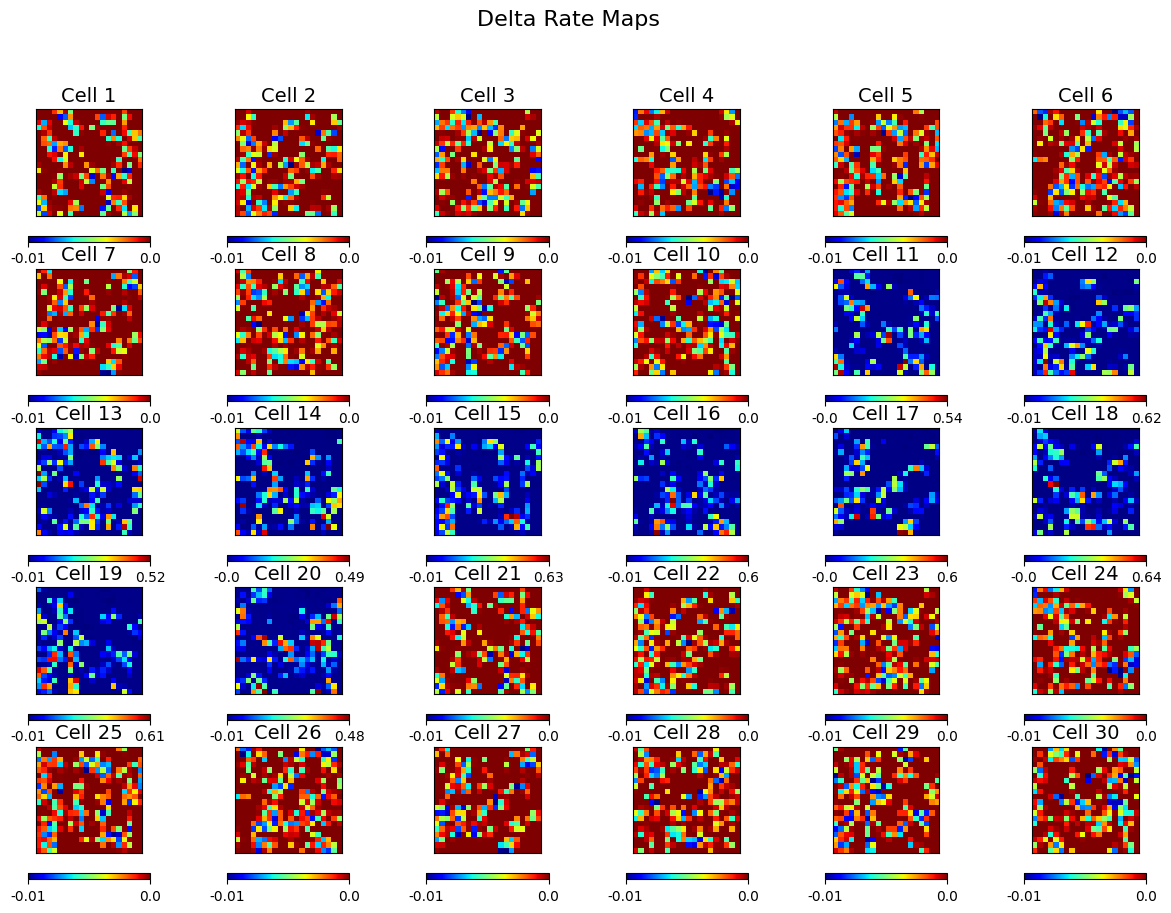

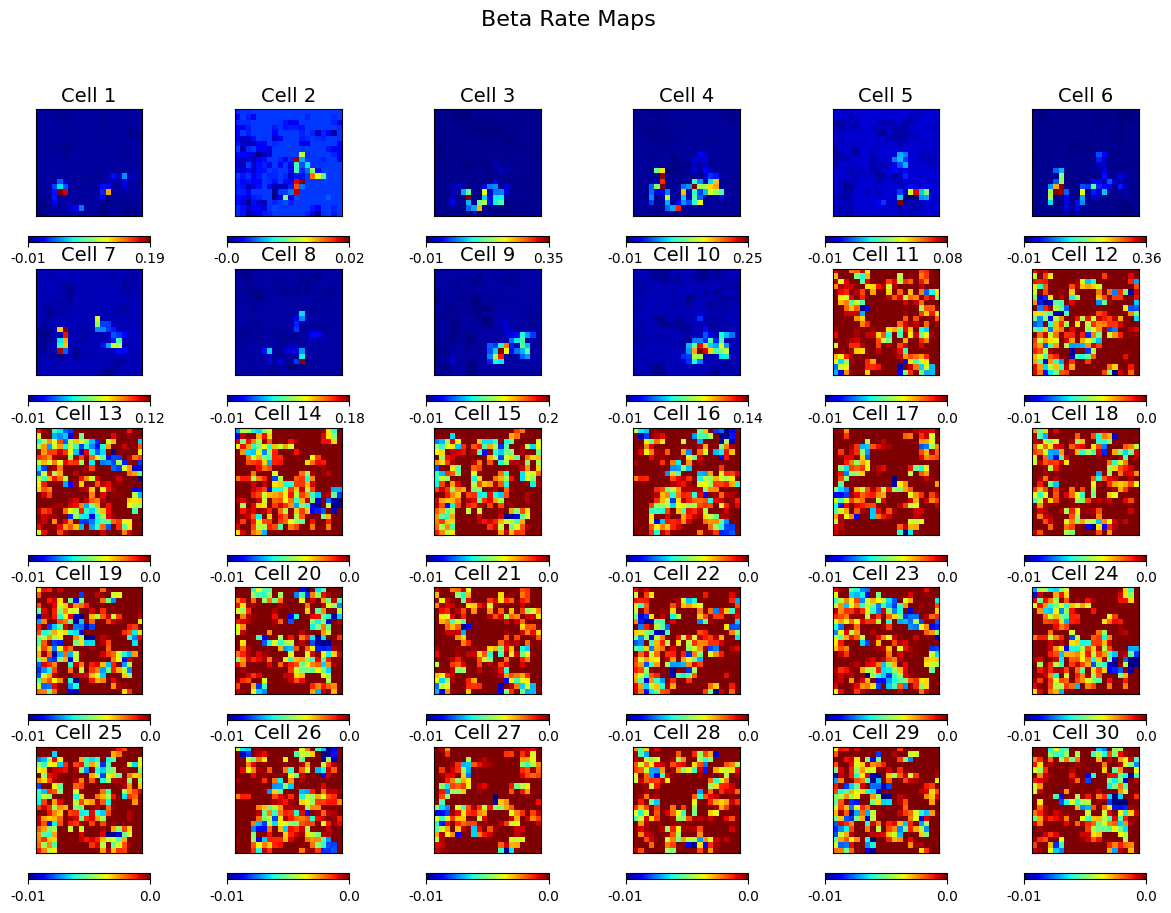

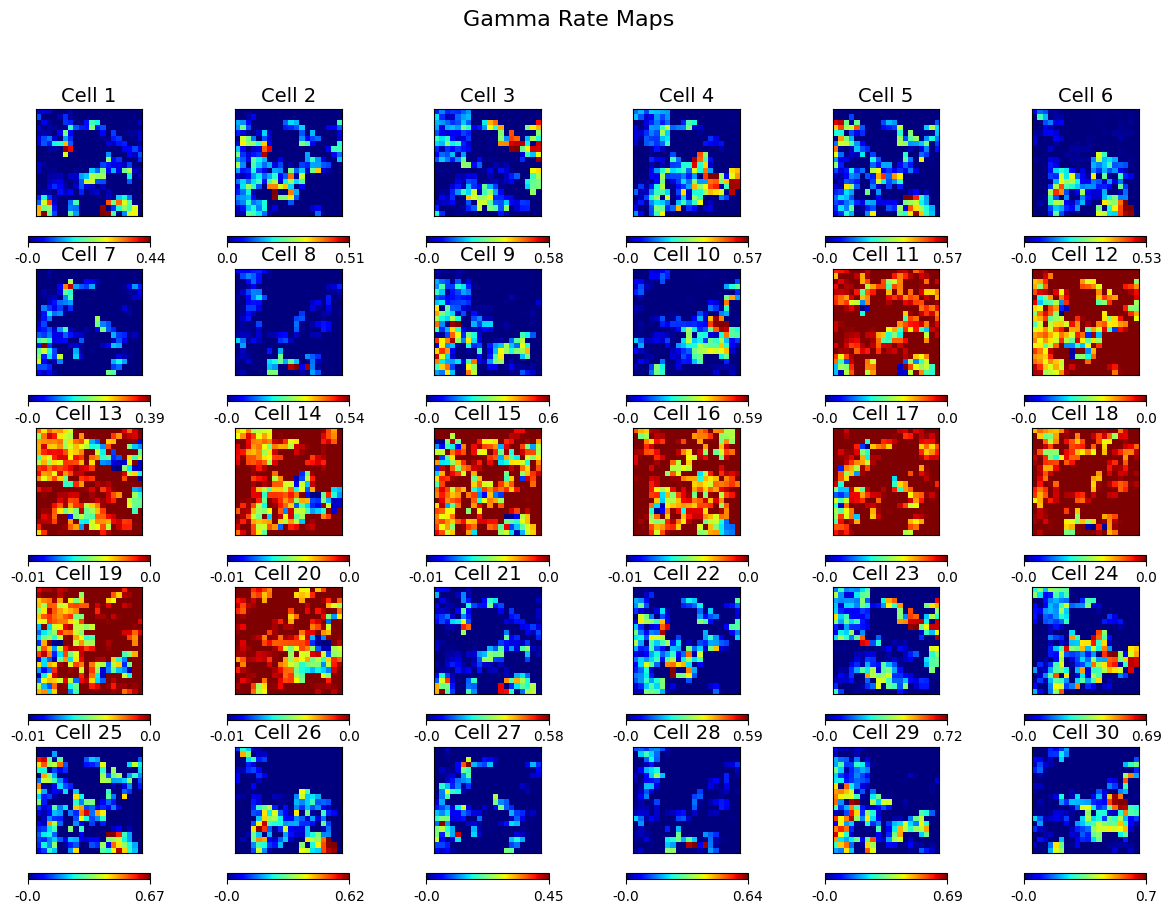

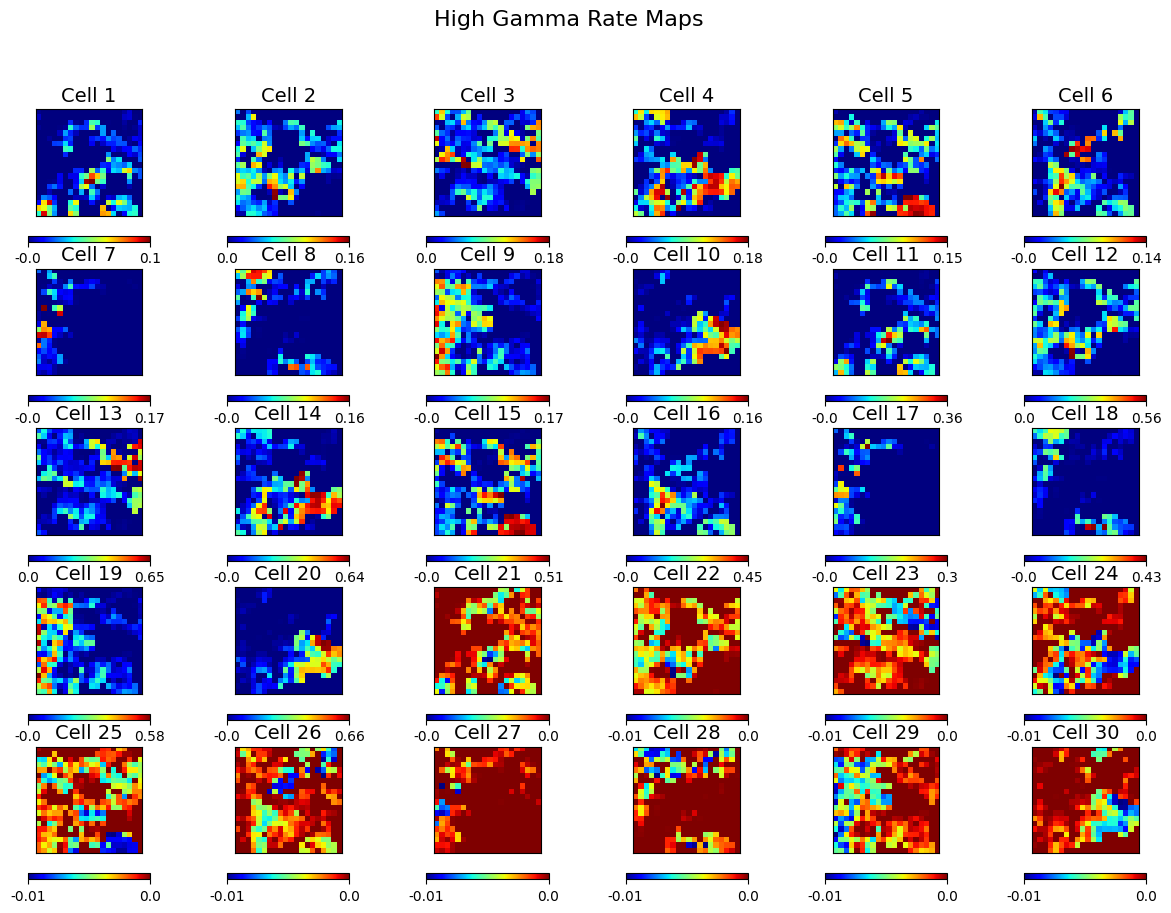

In [8]:
agent.plot_rate_map(rate_map_type='g');
agent.plot_rate_map(rate_map_type='p');

### Scoring and Plotting Grid
Finally, we apply the `GridScorer` metric. The score provides a quantitative measure of the grid's quality.

/Users/lukehollingsworth/Documents/PhD/SaxeLab/NeuralPlayground/NeuralPlayground/neuralplayground/comparison/metrics.py:120: RuntimeWarning: invalid value encountered in sqrt
  mapStd = np.sqrt((sumOfSquares_x * N) - sums_x**2)
/Users/lukehollingsworth/Documents/PhD/SaxeLab/NeuralPlayground/NeuralPlayground/neuralplayground/comparison/metrics.py:122: RuntimeWarning: invalid value encountered in divide
  A = np.squeeze(mapCovar / mapStd / mapStd[::-1, :, :][:, ::-1, :][:, :, :])
/Users/lukehollingsworth/Documents/PhD/SaxeLab/NeuralPlayground/NeuralPlayground/neuralplayground/comparison/metrics.py:120: RuntimeWarning: invalid value encountered in sqrt
  mapStd = np.sqrt((sumOfSquares_x * N) - sums_x**2)
/Users/lukehollingsworth/Documents/PhD/SaxeLab/NeuralPlayground/NeuralPlayground/neuralplayground/comparison/metrics.py:122: RuntimeWarning: invalid value encountered in divide
  A = np.squeeze(mapCovar / mapStd / mapStd[::-1, :, :][:, ::-1, :][:, :, :])


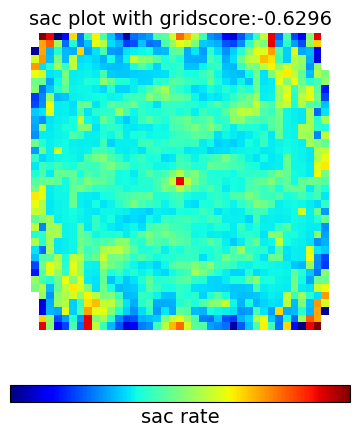

In [9]:
rate_map_mat = agent.get_rate_map_matrix(agent.g_rates,1,2)
GridScorer = GridScorer(rate_map_mat.shape[0])
GridScorer.plot_grid_score(r_out_im = rate_map_mat, plot= True)
score = GridScorer.get_scores(rate_map_mat)